## IMPUTED SQL - PYTHON PIPELINE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine , text
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
import datetime
import time
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import mlflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
server = 'DESKTOP-9ASSRIE\SQLEXPRESS'
database = 'PAI_CA1_IMPUTED'
packages = ['sqlalchemy', 'pyodbc']
engine = create_engine('mssql+pyodbc://{}/{}?driver=SQL Server'.format(server, database))

In [3]:
%%time

## establish connection to database
connection = engine.connect()

## obtain Sensor Data and store in DataFrames
cursor = connection.execute(text('SELECT * FROM Sensor'))
sensor = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Driver Data
cursor = connection.execute(text('SELECT * FROM Driver'))
driver = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Safety Data
cursor = connection.execute(text('SELECT * FROM Safety'))
safety = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## close connection to database
connection.close()

CPU times: total: 34.5 s
Wall time: 34.6 s


In [4]:
sensor

,bookingID,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed
0,0.000000e+00,8.000,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
1,0.000000e+00,8.000,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
2,0.000000e+00,8.000,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454
3,0.000000e+00,8.000,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454
4,0.000000e+00,8.000,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454
...,...,...,...,...,...,...,...,...,...,...,...
7459891,9.964324e+11,3.712,87.000000,-1.908237,8.988108,2.710319,-0.105388,0.442492,0.058795,1538.0,3.574830
7459892,9.964324e+11,3.649,64.000000,-0.909824,8.722343,2.320052,-0.120659,0.332536,0.089949,1539.0,3.235918
7459893,9.964324e+11,3.462,42.000000,-2.490046,9.490906,-0.502798,0.061379,0.327038,0.042912,1540.0,2.388671
7459894,9.964324e+11,3.620,3.000000,-1.498816,10.146936,-0.668003,0.135293,0.243350,0.093003,1542.0,3.794280


In [5]:
safety

,bookingID,driverID,label
0,0.000000e+00,48.0,0
1,1.000000e+00,74.0,1
2,1.000000e+01,75.0,0
3,1.005022e+12,64.0,1
4,1.005022e+12,49.0,1
...,...,...,...
19995,9.964324e+11,57.0,0
19996,9.964324e+11,27.0,0
19997,9.964324e+11,70.0,0
19998,9.964324e+11,87.0,0


In [6]:
driver

,driverID,name,date_of_birth,gender,car_model,car_make_year,rating
0,1.0,Tressa,1992-01-12,Female,Mazda,2011,4.5
1,2.0,Virgilio,1992-10-23,Male,Mazda,2004,3.5
2,3.0,Bert,1989-08-10,Male,Nissan,2008,4.5
3,4.0,Mahmoud,1981-08-14,Male,Toyota,2008,4.5
4,5.0,Felecia,1990-07-20,Female,Hyundai,2010,4.5
...,...,...,...,...,...,...,...
143,144.0,Adena,1982-12-31,Female,Chevrolet,2011,4.0
144,145.0,Shari,1992-11-19,Female,Mazda,2011,5.0
145,146.0,Sid,1984-06-29,Male,Volkswagen,2010,5.0
146,147.0,Delila,1982-11-08,Female,Toyota,2011,3.0


## Merge DF By BookingID + Column Aggregation

In [7]:
merged_1 = pd.merge(safety, driver, on='driverID')
merged_1 = merged_1.drop(columns=['driverID', 'name'])
merged_df = pd.merge(sensor, merged_1, on='bookingID')

In [8]:
merged_df

,bookingID,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,label,date_of_birth,gender,car_model,car_make_year,rating
0,0.000000e+00,8.000,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
1,0.000000e+00,8.000,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
2,0.000000e+00,8.000,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
3,0.000000e+00,8.000,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
4,0.000000e+00,8.000,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7459891,9.964324e+11,3.712,87.000000,-1.908237,8.988108,2.710319,-0.105388,0.442492,0.058795,1538.0,3.574830,1,1991-08-27,Male,Chevrolet,2008,3.5
7459892,9.964324e+11,3.649,64.000000,-0.909824,8.722343,2.320052,-0.120659,0.332536,0.089949,1539.0,3.235918,1,1991-08-27,Male,Chevrolet,2008,3.5
7459893,9.964324e+11,3.462,42.000000,-2.490046,9.490906,-0.502798,0.061379,0.327038,0.042912,1540.0,2.388671,1,1991-08-27,Male,Chevrolet,2008,3.5
7459894,9.964324e+11,3.620,3.000000,-1.498816,10.146936,-0.668003,0.135293,0.243350,0.093003,1542.0,3.794280,1,1991-08-27,Male,Chevrolet,2008,3.5


In [34]:
male = merged_df[merged_df['gender'] == 'Male']
female = merged_df[merged_df['gender'] == 'Female']


print('total males: ' + str(len(male)))
print('total females: ' + str(len(female)))

total males: 4669241
total females: 2790655


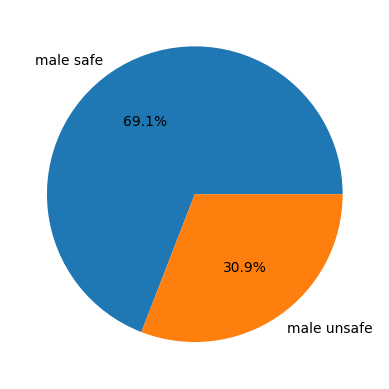

In [31]:
male = merged_df[merged_df['gender'] == 'Male']
male_safe = len(male[male['label'] == 0])
male_unsafe = len(male[male['label'] == 1])

pieVals = [male_safe, male_unsafe]
labels = ['male safe', 'male unsafe']
plt.pie(pieVals, labels=labels, autopct='%1.1f%%')
plt.show()

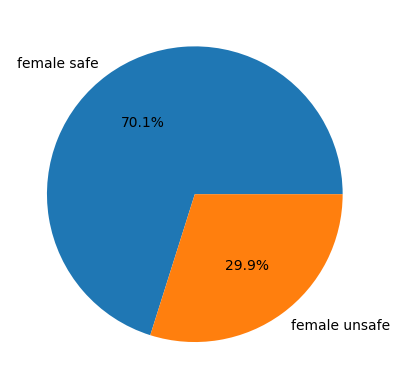

In [32]:
female = merged_df[merged_df['gender'] == 'Female']
female_safe = len(female[female['label'] == 0])
female_unsafe = len(female[female['label'] == 1])

pieVals = [female_safe, female_unsafe]
labels = ['female safe', 'female unsafe']
plt.pie(pieVals, labels=labels, autopct='%1.1f%%')
plt.show()

mers unsafe: 0.30414885216855403
hyundai unsafe: 0.31223960254802136
nissan unsafe: 0.2901205810705788
chev unsafe: 0.27846635586552027
honda unsafe: 0.32078279322950354
mazda unsafe: 0.30378987081285014
toyota unsafe: 0.3076365834373341
ford unsafe: 0.3160799732831
volks unsafe: 0.3084180799679017
bmw unsafe: 0.30302811303028115


<BarContainer object of 10 artists>

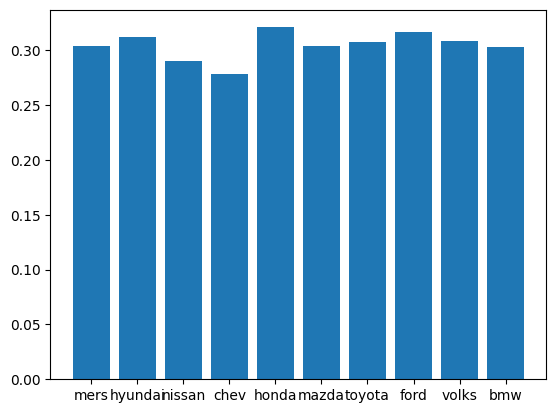

In [43]:
mers = merged_df[merged_df['car_model'] == 'Mercedes-Benz']
hyundai = merged_df[merged_df['car_model'] == 'Hyundai']
nissan = merged_df[merged_df['car_model'] == 'Nissan']
chev = merged_df[merged_df['car_model'] == 'Chevrolet']
honda = merged_df[merged_df['car_model'] == 'Honda']
mazda = merged_df[merged_df['car_model'] == 'Mazda']
toyota = merged_df[merged_df['car_model'] == 'Toyota']
ford = merged_df[merged_df['car_model'] == 'Ford']
volks = merged_df[merged_df['car_model'] == 'Volkswagen']
bmw = merged_df[merged_df['car_model'] == 'BMW']

cars = [mers, hyundai, nissan, chev, honda, mazda, toyota, ford, volks, bmw]
car_names = ['mers', 'hyundai', 'nissan', 'chev', 'honda', 'mazda', 'toyota', 'ford', 'volks', 'bmw']
values = []

for car in range(len(cars)):
    curr = cars[car]
    curr_name = car_names[car]
    unsafe = len(curr[curr['label'] == 1])
    print(f'{curr_name} unsafe: {unsafe/len(curr)}')
    values.append(unsafe/len(curr))


plt.bar(car_names, values)


In [65]:
# convert date_of_birth into driver's age
dob = merged_df['date_of_birth']
ageArr = []

for date in range(len(dob)):
    age = 2019 - int(dob[date][0:4])
    ageArr.append(age)

# replace date_of_birth column with age
merged_df['date_of_birth'] = ageArr

merged_df

,bookingID,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,label,date_of_birth,gender,car_model,car_make_year,rating
0,0.000000e+00,8.000,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,45,Male,Mercedes-Benz,2013,4.0
1,0.000000e+00,8.000,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,45,Male,Mercedes-Benz,2013,4.0
2,0.000000e+00,8.000,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,0,45,Male,Mercedes-Benz,2013,4.0
3,0.000000e+00,8.000,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454,0,45,Male,Mercedes-Benz,2013,4.0
4,0.000000e+00,8.000,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454,0,45,Male,Mercedes-Benz,2013,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7459891,9.964324e+11,3.712,87.000000,-1.908237,8.988108,2.710319,-0.105388,0.442492,0.058795,1538.0,3.574830,1,28,Male,Chevrolet,2008,3.5
7459892,9.964324e+11,3.649,64.000000,-0.909824,8.722343,2.320052,-0.120659,0.332536,0.089949,1539.0,3.235918,1,28,Male,Chevrolet,2008,3.5
7459893,9.964324e+11,3.462,42.000000,-2.490046,9.490906,-0.502798,0.061379,0.327038,0.042912,1540.0,2.388671,1,28,Male,Chevrolet,2008,3.5
7459894,9.964324e+11,3.620,3.000000,-1.498816,10.146936,-0.668003,0.135293,0.243350,0.093003,1542.0,3.794280,1,28,Male,Chevrolet,2008,3.5


In [66]:
# group by Team, get mean, min, and max value of Age for each value of Team.
merged_df_num = merged_df.groupby('bookingID').agg({
     'accuracy': ['mean', 'median', 'min', 'max'],
     'bearing': ['mean', 'median', 'min', 'max'],
     'acceleration_x': ['mean', 'median', 'min', 'max'],
     'acceleration_y': ['mean', 'median', 'min', 'max'],
     'acceleration_z': ['mean', 'median', 'min', 'max'],
     'gyro_x': ['mean', 'median', 'min', 'max'],
     'gyro_y': ['mean', 'median', 'min', 'max'],
     'gyro_z': ['mean', 'median', 'min', 'max'],
     'second': ['mean', 'median', 'min', 'max'],
     'speed': ['mean', 'median', 'min', 'max'],
     'date_of_birth': ['mean'],
     'car_make_year': ['mean'],
     'rating': ['mean'],
     'label': ['mean']
     })

merged_df_num = merged_df_num.reset_index()
## https://jamesrledoux.com/code/group-by-aggregate-pandas

In [67]:
merged_df_cat = merged_df.groupby('bookingID')[['gender', 'car_model']].agg(lambda x: x.value_counts().index[0])
merged_df_cat = merged_df_cat.reset_index()

In [68]:
merged_df = pd.merge(merged_df_num, merged_df_cat, on='bookingID', how='left')
merged_df = merged_df.drop(columns=['bookingID'])
merged_df

,"(bookingID, )","(accuracy, mean)","(accuracy, median)","(accuracy, min)","(accuracy, max)","(bearing, mean)","(bearing, median)","(bearing, min)","(bearing, max)","(acceleration_x, mean)",...,"(speed, mean)","(speed, median)","(speed, min)","(speed, max)","(date_of_birth, mean)","(car_make_year, mean)","(rating, mean)","(label, mean)",gender,car_model
0,0.000000e+00,9.876652,8.000,4.000,48.000,176.568456,144.299423,0.037464,359.979767,-0.704909,...,9.044214,8.707954,-1.0,22.882523,45.0,2013.0,4.0,0.0,Male,Mercedes-Benz
1,1.000000e+00,3.719780,4.000,3.000,7.709,125.318182,111.000000,0.000000,337.000000,-0.509291,...,7.530312,6.592251,-1.0,21.882141,41.0,2011.0,3.5,1.0,Male,Hyundai
2,2.000000e+00,3.794337,3.413,3.000,8.000,184.403614,235.500000,11.000000,330.000000,0.276034,...,2.821090,2.582209,0.0,9.257438,36.0,2011.0,4.0,1.0,Male,Toyota
3,4.000000e+00,10.000000,10.000,10.000,10.000,149.305491,133.643135,2.271227,351.409851,-0.377782,...,6.056069,3.430000,0.0,19.559999,28.0,2008.0,3.5,1.0,Male,Volkswagen
4,6.000000e+00,4.607496,4.081,3.000,12.000,194.290875,259.000000,0.000000,346.000000,0.552613,...,4.641173,1.936962,0.0,16.394695,45.0,2005.0,4.5,0.0,Male,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,1.709397e+12,4.082112,3.010,3.000,43.317,169.047210,165.000000,0.000000,359.000000,0.093675,...,2.402633,2.716089,-1.0,6.275580,39.0,2011.0,4.0,1.0,Male,Volkswagen
19995,1.709397e+12,11.898256,12.000,4.000,25.000,177.555276,181.007385,10.027151,348.479736,0.561403,...,7.544601,5.964618,0.0,24.059151,38.0,2011.0,4.0,1.0,Male,Toyota
19996,1.709397e+12,9.366045,9.648,5.953,11.792,197.028329,196.000000,0.000000,359.000000,-0.206549,...,12.681133,15.540000,0.0,25.640000,34.0,2008.0,3.0,1.0,Male,Hyundai
19997,1.709397e+12,5.122080,4.000,3.000,48.000,205.463115,244.500000,1.000000,357.000000,0.738153,...,6.007374,5.054384,0.0,19.287226,29.0,2011.0,3.0,1.0,Male,Ford


In [69]:
merged_df.columns

Index([           ('bookingID', ''),         ('accuracy', 'mean'),
             ('accuracy', 'median'),          ('accuracy', 'min'),
                ('accuracy', 'max'),          ('bearing', 'mean'),
              ('bearing', 'median'),           ('bearing', 'min'),
                 ('bearing', 'max'),   ('acceleration_x', 'mean'),
       ('acceleration_x', 'median'),    ('acceleration_x', 'min'),
          ('acceleration_x', 'max'),   ('acceleration_y', 'mean'),
       ('acceleration_y', 'median'),    ('acceleration_y', 'min'),
          ('acceleration_y', 'max'),   ('acceleration_z', 'mean'),
       ('acceleration_z', 'median'),    ('acceleration_z', 'min'),
          ('acceleration_z', 'max'),           ('gyro_x', 'mean'),
               ('gyro_x', 'median'),            ('gyro_x', 'min'),
                  ('gyro_x', 'max'),           ('gyro_y', 'mean'),
               ('gyro_y', 'median'),            ('gyro_y', 'min'),
                  ('gyro_y', 'max'),           ('gyro_z', 'mea

## Column Renaming & Reordering

In [70]:
# merge_df = merged_df.drop(columns=['label'])
merged_df.columns = ['bookingID', 'accuracy mean', 'accuracy median', 'accuracy min', 'accuracy max',
                    'bearing mean', 'bearing median', 'bearing min', 'bearing max',
                    'acceleration_x mean', 'acceleration_x median', 'acceleration_x min', 'acceleration_x max',
                    'acceleration_y mean', 'acceleration_y median', 'acceleration_y min', 'acceleration_y max',
                    'acceleration_z mean', 'acceleration_z median', 'acceleration_z min', 'acceleration_z max',
                    'gyro_x mean', 'gyro_x median', 'gyro_x min', 'gyro_x max',
                    'gyro_y mean', 'gyro_y median', 'gyro_y min', 'gyro_y max',
                    'gyro_z mean', 'gyro_z median', 'gyro_z min', 'gyro_z max',
                    'second mean', 'second median', 'second min', 'second max',
                    'speed mean', 'speed median', 'speed min', 'speed max',
                    'age', 'car_make_year', 'rating', 'label', 'gender', 'car_model']

In [71]:
merged_df = merged_df.drop(columns=['bookingID'])
merged_df = merged_df.reindex(columns=[
    'accuracy mean', 'accuracy median', 'accuracy min', 'accuracy max',
    'bearing mean', 'bearing median', 'bearing min', 'bearing max',
    'acceleration_x mean', 'acceleration_x median', 'acceleration_x min', 'acceleration_x max',
    'acceleration_y mean', 'acceleration_y median', 'acceleration_y min', 'acceleration_y max',
    'acceleration_z mean', 'acceleration_z median', 'acceleration_z min', 'acceleration_z max',
    'gyro_x mean', 'gyro_x median', 'gyro_x min', 'gyro_x max',
    'gyro_y mean', 'gyro_y median', 'gyro_y min', 'gyro_y max',
    'gyro_z mean', 'gyro_z median', 'gyro_z min', 'gyro_z max',
    'second mean', 'second median', 'second min', 'second max',
    'speed mean', 'speed median', 'speed min', 'speed max',
    'age', 'car_make_year', 'rating', 'gender', 'car_model', 'label'
])

In [72]:
merged_df

,accuracy mean,accuracy median,accuracy min,accuracy max,bearing mean,bearing median,bearing min,bearing max,acceleration_x mean,acceleration_x median,...,speed mean,speed median,speed min,speed max,age,car_make_year,rating,gender,car_model,label
0,9.876652,8.000,4.000,48.000,176.568456,144.299423,0.037464,359.979767,-0.704909,-0.752466,...,9.044214,8.707954,-1.0,22.882523,45.0,2013.0,4.0,Male,Mercedes-Benz,0.0
1,3.719780,4.000,3.000,7.709,125.318182,111.000000,0.000000,337.000000,-0.509291,-0.547315,...,7.530312,6.592251,-1.0,21.882141,41.0,2011.0,3.5,Male,Hyundai,1.0
2,3.794337,3.413,3.000,8.000,184.403614,235.500000,11.000000,330.000000,0.276034,0.332804,...,2.821090,2.582209,0.0,9.257438,36.0,2011.0,4.0,Male,Toyota,1.0
3,10.000000,10.000,10.000,10.000,149.305491,133.643135,2.271227,351.409851,-0.377782,-0.388345,...,6.056069,3.430000,0.0,19.559999,28.0,2008.0,3.5,Male,Volkswagen,1.0
4,4.607496,4.081,3.000,12.000,194.290875,259.000000,0.000000,346.000000,0.552613,0.490826,...,4.641173,1.936962,0.0,16.394695,45.0,2005.0,4.5,Male,BMW,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,4.082112,3.010,3.000,43.317,169.047210,165.000000,0.000000,359.000000,0.093675,0.083800,...,2.402633,2.716089,-1.0,6.275580,39.0,2011.0,4.0,Male,Volkswagen,1.0
19995,11.898256,12.000,4.000,25.000,177.555276,181.007385,10.027151,348.479736,0.561403,0.586705,...,7.544601,5.964618,0.0,24.059151,38.0,2011.0,4.0,Male,Toyota,1.0
19996,9.366045,9.648,5.953,11.792,197.028329,196.000000,0.000000,359.000000,-0.206549,-0.163261,...,12.681133,15.540000,0.0,25.640000,34.0,2008.0,3.0,Male,Hyundai,1.0
19997,5.122080,4.000,3.000,48.000,205.463115,244.500000,1.000000,357.000000,0.738153,0.998413,...,6.007374,5.054384,0.0,19.287226,29.0,2011.0,3.0,Male,Ford,1.0


## Feature Importance

In [78]:
# encode categorical values
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), [43, 44])
], remainder='passthrough')

Feature: 0, Score: 0.00252
Feature: 1, Score: 0.00265
Feature: 2, Score: 0.00076
Feature: 3, Score: 0.00161
Feature: 4, Score: 0.00202
Feature: 5, Score: 0.00192
Feature: 6, Score: 0.00200
Feature: 7, Score: 0.00222
Feature: 8, Score: 0.00143
Feature: 9, Score: 0.00211
Feature: 10, Score: 0.00277
Feature: 11, Score: 0.00226
Feature: 12, Score: 0.02141
Feature: 13, Score: 0.01451
Feature: 14, Score: 0.00595
Feature: 15, Score: 0.01901
Feature: 16, Score: 0.02179
Feature: 17, Score: 0.02105
Feature: 18, Score: 0.01205
Feature: 19, Score: 0.01960
Feature: 20, Score: 0.02115
Feature: 21, Score: 0.02113
Feature: 22, Score: 0.02497
Feature: 23, Score: 0.02520
Feature: 24, Score: 0.02030
Feature: 25, Score: 0.02048
Feature: 26, Score: 0.02249
Feature: 27, Score: 0.02236
Feature: 28, Score: 0.01947
Feature: 29, Score: 0.01940
Feature: 30, Score: 0.02288
Feature: 31, Score: 0.02555
Feature: 32, Score: 0.02193
Feature: 33, Score: 0.02050
Feature: 34, Score: 0.02481
Feature: 35, Score: 0.02584
Fe

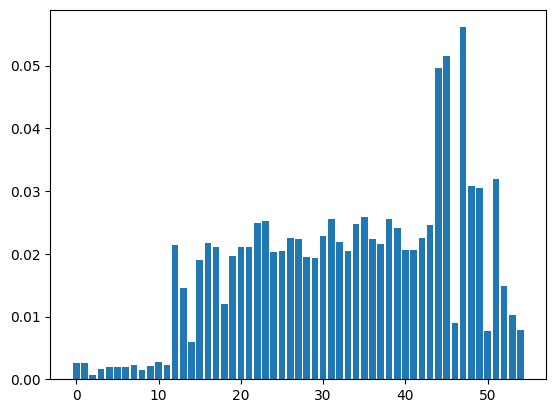

(19999, 45)
(19999,)
55


In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

merge_df = merged_df.copy()

X = merge_df.drop(columns=['label'])
y = merge_df['label']

# define the model
model = RandomForestClassifier(random_state=42)
# fit the model
pipeline = Pipeline([('ohe', ohe), ('StandardScaler', StandardScaler()),('RFC', model)])
pipeline.fit(X, y)
# get importance
importance = model.feature_importances_
feature, score = [], []

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    feature.append(i)
    score.append(v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(X.shape)
print(y.shape)
print(len(importance))

In [80]:
data = {'feature': feature, 'score': score}
sortImpt = pd.DataFrame(columns=['feature', 'score'], data=data)
sortImpt.sort_values(by=['score'], ascending=False)

,feature,score
47,47,0.056110
45,45,0.051591
44,44,0.049644
51,51,0.031967
48,48,0.030773
49,49,0.030498
35,35,0.025840
31,31,0.025546
38,38,0.025528
23,23,0.025196


## Factor Analysis Of Mixed Data (FAMD)

In [92]:
from prince import FAMD
import matplotlib.ticker as ticker

In [93]:
merge_df = merged_df.copy()

X = merge_df.drop(columns=['label'])

scaled_X = StandardScaler().fit_transform(X[[
    'accuracy mean', 'accuracy median', 'accuracy min', 'accuracy max',
    'bearing mean', 'bearing median', 'bearing min', 'bearing max',
    'acceleration_x mean', 'acceleration_x median', 'acceleration_x min', 'acceleration_x max',
    'acceleration_y mean', 'acceleration_y median', 'acceleration_y min', 'acceleration_y max',
    'acceleration_z mean', 'acceleration_z median', 'acceleration_z min', 'acceleration_z max',
    'gyro_x mean', 'gyro_x median', 'gyro_x min', 'gyro_x max',
    'gyro_y mean', 'gyro_y median', 'gyro_y min', 'gyro_y max',
    'gyro_z mean', 'gyro_z median', 'gyro_z min', 'gyro_z max',
    'second mean', 'second median', 'second min', 'second max',
    'speed mean', 'speed median', 'speed min', 'speed max',
    'age', 'car_make_year', 'rating']])

X[[
    'accuracy mean', 'accuracy median', 'accuracy min', 'accuracy max',
    'bearing mean', 'bearing median', 'bearing min', 'bearing max',
    'acceleration_x mean', 'acceleration_x median', 'acceleration_x min', 'acceleration_x max',
    'acceleration_y mean', 'acceleration_y median', 'acceleration_y min', 'acceleration_y max',
    'acceleration_z mean', 'acceleration_z median', 'acceleration_z min', 'acceleration_z max',
    'gyro_x mean', 'gyro_x median', 'gyro_x min', 'gyro_x max',
    'gyro_y mean', 'gyro_y median', 'gyro_y min', 'gyro_y max',
    'gyro_z mean', 'gyro_z median', 'gyro_z min', 'gyro_z max',
    'second mean', 'second median', 'second min', 'second max',
    'speed mean', 'speed median', 'speed min', 'speed max',
    'age', 'car_make_year', 'rating']] = scaled_X

X

,accuracy mean,accuracy median,accuracy min,accuracy max,bearing mean,bearing median,bearing min,bearing max,acceleration_x mean,acceleration_x median,...,second max,speed mean,speed median,speed min,speed max,age,car_make_year,rating,gender,car_model
0,-0.005129,0.038257,-0.002216,-0.156978,0.159186,-0.320962,-0.316480,0.449285,-0.774965,-0.810114,...,1.427142,0.144427,0.138007,-0.491844,0.395758,1.304164,1.489465,-0.148158,Male,Mercedes-Benz
1,-0.185819,-0.098346,-0.097641,-0.289679,-0.846924,-0.766369,-0.317570,-0.121397,-0.579896,-0.610101,...,0.251592,-0.205733,-0.231594,-0.491844,0.205086,0.706437,0.656041,-1.073518,Male,Hyundai
2,-0.183631,-0.118392,-0.097641,-0.288720,0.313000,0.898921,0.002503,-0.295235,0.203222,0.247974,...,-0.197447,-1.294959,-0.932125,0.081438,-2.201177,-0.040722,0.656041,-0.148158,Male,Toyota
3,-0.001509,0.106559,0.570331,-0.282133,-0.376022,-0.463499,-0.251483,0.236459,-0.448757,-0.455113,...,0.374442,-0.546720,-0.784021,0.081438,-0.237513,-1.236177,-0.594094,-1.073518,Male,Volkswagen
4,-0.159767,-0.095579,-0.097641,-0.275546,0.507100,1.213253,-0.317570,0.102110,0.479024,0.402038,...,0.374442,-0.873980,-1.044846,0.081438,-0.840819,1.304164,-1.844230,0.777203,Male,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,-0.175186,-0.132155,-0.097641,-0.172402,0.011534,-0.044075,-0.317570,0.424953,0.021375,0.005206,...,0.495174,-1.391746,-0.908737,-0.491844,-2.769518,0.407573,0.656041,-0.148158,Male,Volkswagen
19995,0.054201,0.174860,-0.002216,-0.232730,0.178558,0.170037,-0.025805,0.163692,0.487789,0.495516,...,-0.224983,-0.202428,-0.341238,0.081438,0.620023,0.258141,0.656041,-0.148158,Male,Toyota
19996,-0.020114,0.094538,0.184148,-0.276231,0.560839,0.370576,-0.317570,0.424953,-0.278005,-0.235667,...,0.154159,0.985633,1.331525,0.081438,0.921333,-0.339586,-0.594094,-1.998879,Male,Hyundai
19997,-0.144665,-0.098346,-0.097641,-0.156978,0.726425,1.019303,-0.288473,0.375285,0.664042,0.896912,...,0.340552,-0.557983,-0.500250,0.081438,-0.289504,-1.086745,0.656041,-1.998879,Male,Ford


In [94]:
n = np.arange(2, 20)
print('Explained Inertia Of Components(n)')
for i in range(len(n)):
    famd = FAMD(n_components=n[i], n_iter=10).fit(X)
    print(str(n[i]) + ' components: ' + str(famd.explained_inertia_.sum()))

Explained Inertia Of Components(n)
2 components: 0.13243717315006992
3 components: 0.19475860326652383
4 components: 0.24044063226817944
5 components: 0.2853493803697368
6 components: 0.33004148017316176
7 components: 0.374299686177081
8 components: 0.41814871376993096
9 components: 0.461716230695918
10 components: 0.5050100187458654
11 components: 0.5481314755076269
12 components: 0.5904597079803358
13 components: 0.6273403337449984
14 components: 0.6579976001507786
15 components: 0.6878968465803593
16 components: 0.714989808757811
17 components: 0.7406159553358764
18 components: 0.7656115382244958
19 components: 0.7896631989728287


<Figure size 640x480 with 0 Axes>

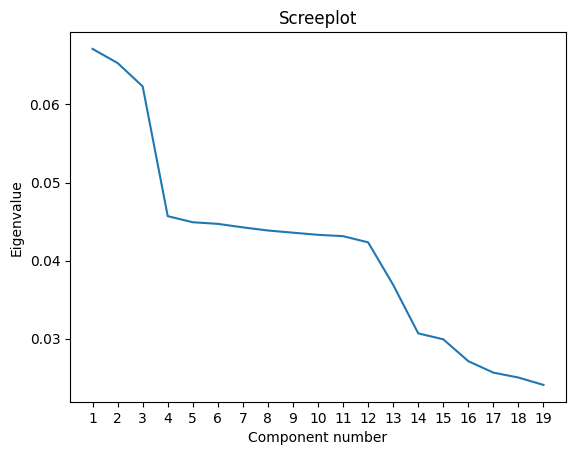

In [95]:
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(famd.explained_inertia_)+1), famd.explained_inertia_)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

In [ ]:
# CODE FOR TRANSFORMING DATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

# PC = FAMD(n_components=3, n_iter=10)
# PC_fit = PC.fit(X)
# PC = PC_fit.transform(X)

## Principal Component Analysis (MAI)

In [82]:
## import relevant modules to perform Principal Component Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data_reduced = merge_df
data_reduced = pd.DataFrame(scale(data_reduced), columns=[data_reduced.columns])
print(data_reduced[data_reduced.isna().any(axis=1)])

pca = PCA(n_components=40).fit(data_reduced)
#Note that pca.transform() returns scores based on centred data
pca_samples = pca.transform(data_reduced)

# Computes the PCs and percentage variance explained
# Pass original data and returns of PCA to this function.
# This function returns a table summarising the eigenvalues, % variance explained, cumulative % variance explained and PCs

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    #PCA cumulative variance explained
    cum_ratios = pca.explained_variance_ratio_.cumsum().reshape(len(pca.components_), 1) 
    cum_variance_ratios = pd.DataFrame(np.round(cum_ratios, 4), columns = ['Cumulative Explained Variance']) 
    cum_variance_ratios.index = dimensions
    
    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, cum_variance_ratios, components], axis = 1)

pca_results = pca_results(data_reduced, pca)
pca_results

Empty DataFrame
Columns: [(accuracy mean,), (accuracy median,), (accuracy min,), (accuracy max,), (bearing mean,), (bearing median,), (bearing min,), (bearing max,), (acceleration_x mean,), (acceleration_x median,), (acceleration_x min,), (acceleration_x max,), (acceleration_y mean,), (acceleration_y median,), (acceleration_y min,), (acceleration_y max,), (acceleration_z mean,), (acceleration_z median,), (acceleration_z min,), (acceleration_z max,), (gyro_x mean,), (gyro_x median,), (gyro_x min,), (gyro_x max,), (gyro_y mean,), (gyro_y median,), (gyro_y min,), (gyro_y max,), (gyro_z mean,), (gyro_z median,), (gyro_z min,), (gyro_z max,), (second mean,), (second median,), (second min,), (second max,), (speed mean,), (speed median,), (speed min,), (speed max,)]
Index: []

[0 rows x 40 columns]


,Eigenvalue,Explained Variance,Cumulative Explained Variance,"(accuracy mean,)","(accuracy median,)","(accuracy min,)","(accuracy max,)","(bearing mean,)","(bearing median,)","(bearing min,)",...,"(gyro_z min,)","(gyro_z max,)","(second mean,)","(second median,)","(second min,)","(second max,)","(speed mean,)","(speed median,)","(speed min,)","(speed max,)"
PC 1,5.1471,0.1287,0.1287,-0.0920,-0.0619,-0.0709,-0.0152,-0.0752,-0.0606,-0.1162,...,-0.1799,0.1831,0.1453,0.1430,0.0141,0.1492,-0.0097,-0.0064,-0.0759,0.0367
PC 2,4.8793,0.1220,0.2506,0.1177,0.0801,0.0547,0.0913,0.0339,0.0244,-0.0486,...,-0.2517,0.2534,0.2063,0.2032,0.0069,0.2123,0.0112,0.0086,-0.0635,0.0573
PC 3,3.5603,0.0890,0.3397,0.0210,0.0481,0.0401,-0.0928,-0.0913,-0.0954,0.0378,...,-0.1607,0.1599,-0.3536,-0.3469,-0.0178,-0.3494,-0.3900,-0.3749,-0.0308,-0.4099
PC 4,2.4037,0.0601,0.3997,0.1637,0.1272,0.0967,0.1201,-0.2286,-0.2254,-0.3079,...,0.1663,-0.1605,0.2204,0.2216,0.0321,0.2169,-0.3443,-0.3324,-0.3475,-0.1695
PC 5,2.3453,0.0586,0.4584,0.0638,0.0476,0.0297,0.0437,-0.0411,-0.0414,-0.0534,...,0.0325,-0.0227,0.0433,0.0442,0.0133,0.0420,-0.0587,-0.0550,-0.0509,-0.0365
PC 6,2.1242,0.0531,0.5115,-0.0379,-0.0357,-0.0231,-0.0203,-0.0400,-0.0385,-0.0029,...,-0.0322,0.0519,-0.0111,-0.0102,-0.0119,-0.0128,0.0306,0.0292,0.0298,0.0164
PC 7,2.0091,0.0502,0.5617,0.4376,0.4160,0.3352,0.2227,-0.1335,-0.1324,0.0730,...,-0.0424,0.0290,-0.0363,-0.0392,0.0057,-0.0312,0.1189,0.1143,0.0952,0.0610
PC 8,1.9585,0.0490,0.6107,0.0089,0.0054,-0.0022,0.0348,-0.5180,-0.5031,-0.0707,...,-0.0294,0.0516,-0.0347,-0.0365,-0.0122,-0.0334,0.1564,0.1492,0.1145,0.1083
PC 9,1.8855,0.0471,0.6578,0.2703,0.2763,0.2018,0.1243,0.2206,0.2141,0.1033,...,0.0547,-0.0016,-0.0425,-0.0443,0.0275,-0.0422,0.0154,0.0157,0.0288,-0.0153
PC 10,1.8345,0.0459,0.7037,-0.1792,-0.1877,-0.1315,-0.1001,-0.0090,-0.0120,-0.0250,...,0.0395,0.0378,0.0484,0.0523,0.0154,0.0415,-0.0526,-0.0527,-0.0268,-0.0352


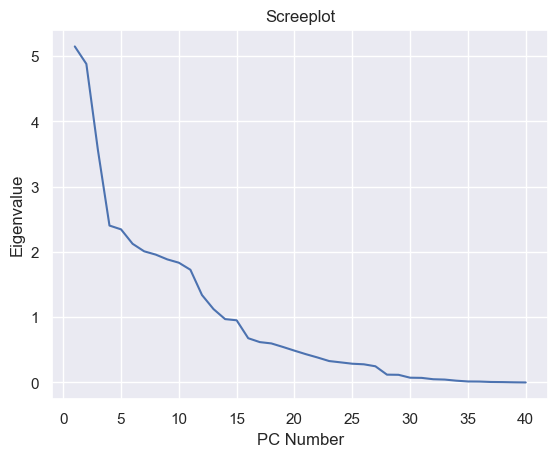

In [83]:
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.title('Screeplot')
plt.xlabel('PC Number')
plt.ylabel('Eigenvalue')
plt.show()

### Identify How Many PCs To Extract <br>
#### Methods: 
##### 1) By Kaiser's Rule, extract PCs whose eigenvalues > 1
##### 2) Keep Cummulative Variance of 80%
##### 3) Scree Plot Elbow (take values on left of elbow)

In [84]:
## extract only the two PCs
pca2 = PCA(n_components=2).fit(data_reduced)
scores2 = pca2.transform(data_reduced)

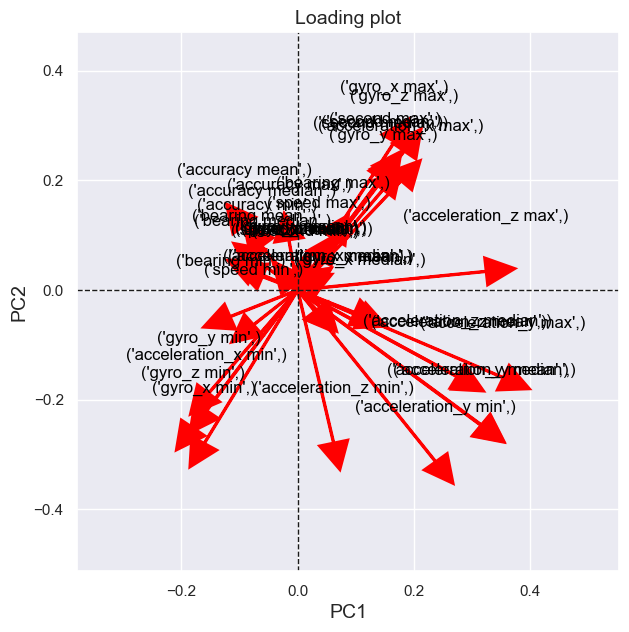

In [85]:
# This function plots the loading plot.
# Pass original data dataframe and returns of PCA to this function. Optional width, height and margin
# This function returns the axes of the loading plot

def loadingplot(data, pca, width=5, height=5, margin=0.5):

    fig, ax = plt.subplots(figsize = (width,height))

    #Set limits for figure
    x_min = min(pca.components_[0,:].min(),0)-margin
    x_max = max(pca.components_[0,:].max(),0)+margin
    y_min = min(pca.components_[1,:].min(),0)-margin
    y_max = max(pca.components_[1,:].max(),0)+margin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    #Scaling factor for text position
    text_pos = 0.1

    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0], v[1], head_width=0.05, head_length=0.05, linewidth=2, color='red')
        ax.text(v[0], v[1]+text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=12)

    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)
    ax.set_title("Loading plot", fontsize = 14)
    
    return ax

plt.clf
ax2 = loadingplot(data_reduced, pca2, width=7, height=7, margin=0.2)
plt.show()

## PCA

>1 0.767 (0.005)
>2 0.767 (0.005)
>3 0.767 (0.005)
>4 0.768 (0.005)
>5 0.767 (0.005)
>6 0.767 (0.006)
>7 0.767 (0.005)
>8 0.767 (0.005)
>9 0.767 (0.005)
>10 0.765 (0.006)
>11 0.764 (0.006)
>12 0.764 (0.007)
>13 0.763 (0.007)
>14 0.765 (0.017)
>15 0.725 (0.018)
>16 0.721 (0.013)
>17 0.722 (0.014)
>18 0.724 (0.015)
>19 0.722 (0.014)
>20 0.725 (0.015)
>21 0.725 (0.012)
>22 0.724 (0.012)
>23 0.721 (0.013)
>24 0.722 (0.012)
>25 0.721 (0.016)
>26 0.721 (0.016)
>27 0.721 (0.013)
>28 0.720 (0.012)
>29 0.723 (0.011)
>30 0.722 (0.015)
>31 0.726 (0.012)
>32 0.724 (0.013)
>33 0.723 (0.013)
>34 0.723 (0.013)
>35 0.725 (0.014)
>36 0.722 (0.013)
>37 0.724 (0.014)
>38 0.724 (0.014)
>39 0.723 (0.013)
>40 0.724 (0.012)


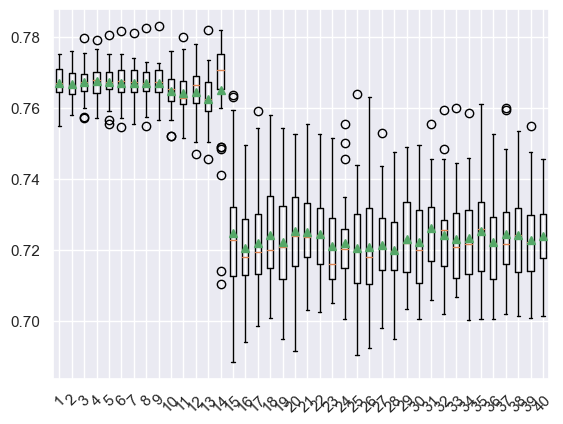

In [86]:
## https://machinelearningmastery.com/principal-components-analysis-for-dimensionality-reduction-in-python/

# compare pca number of components with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

merge_df = merged_df.copy()

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,41):
        steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X = merge_df.drop(columns=['label'])
y = merge_df['label']
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

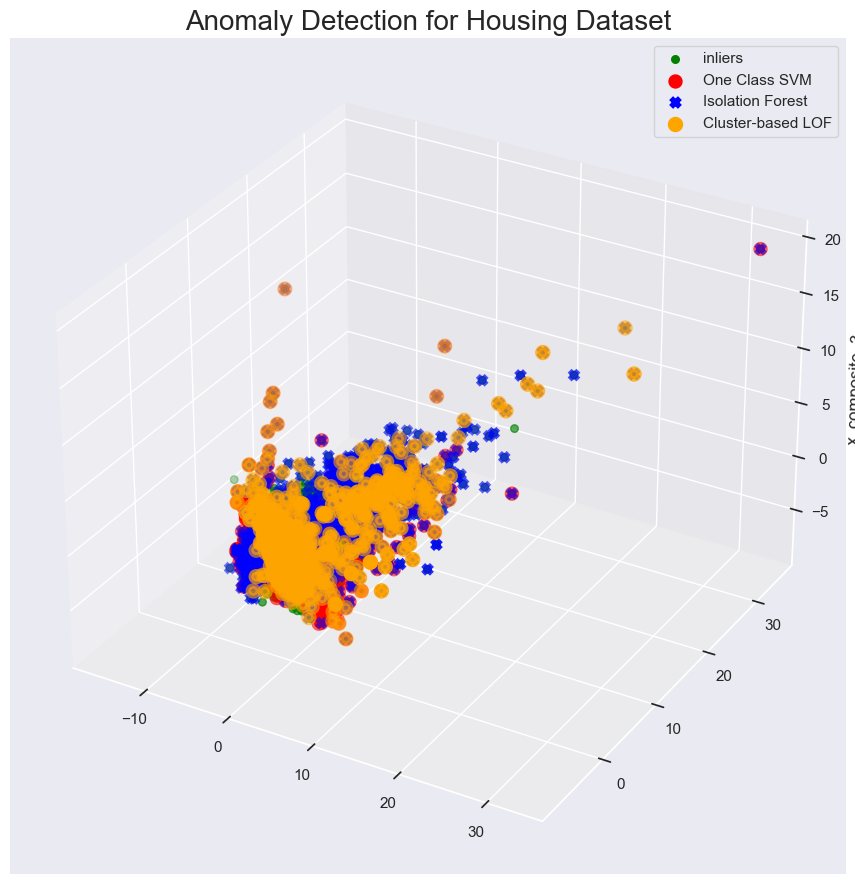

In [90]:
merge_df = merged_df.copy()

# Outlier Detection
classifier_dict = {"One-Class SVM": OneClassSVM(nu=0.05),
                   "Isolation Forest": IsolationForest(contamination=0.05),
                   "Cluster-based LOF": LocalOutlierFactor(contamination=0.05)}
Outliers = pd.DataFrame()
for i, (clf_name, clf) in enumerate(classifier_dict.items()):
    clf.fit(merge_df)
    merge_df["anomaly"] = clf.fit_predict(merge_df)
    outliers_subset = merge_df[merge_df.anomaly == -1]
    outliers_subset = outliers_subset.assign(model = clf_name)
    Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=False)

pca = PCA(n_components=3) # reduce to k=3 dimensions
scaler = StandardScaler()
X = scaler.fit_transform(merged_df)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection="3d")
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=30, lw=1, label="inliers",c="green")
ax.scatter(X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 0],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 1],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 2],
           lw=4, s=40, c="red", label="One Class SVM")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 2],
           lw=4, s=40, marker='x', c="blue", label="Isolation Forest")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 2],
           lw=4, s=50, c="orange", label="Cluster-based LOF")
plt.title("Anomaly Detection for Housing Dataset", fontsize=20)
plt.legend()
plt.tight_layout()

## Isolation Forest Model

In [91]:
from sklearn import metrics
from sklearn.metrics import classification_report
# load the dataset
merge_df = merged_df.copy()
# split into input and output elements
X = merge_df.drop(columns=['label'])
y = merge_df['label']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.05)
x_out = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))

Initial shape of the training dataset (13399, 40) (13399, 1)
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87      4942
         1.0       0.69      0.22      0.33      1658

    accuracy                           0.78      6600
   macro avg       0.74      0.59      0.60      6600
weighted avg       0.76      0.78      0.73      6600

Shape of the training dataset after removing outliers (12729, 40) (12729, 1)
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86      4942
         1.0       0.65      0.19      0.29      1658

    accuracy                           0.77      6600
   macro avg       0.71      0.58      0.58      6600
weighted avg       0.75      0.77      0.72      6600



## Local Outlier Factor Model

In [92]:
from sklearn import metrics
from sklearn.metrics import classification_report
# load the dataset
merge_df = merged_df.copy()
# split into input and output elements
X = merge_df.drop(columns=['label'])
y = merge_df['label']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))


# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.05)
x_out = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))

accuracy = metrics.accuracy_score(y_test, yhat1)

Initial shape of the training dataset (13399, 40) (13399, 1)
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87      4942
         1.0       0.69      0.21      0.32      1658

    accuracy                           0.78      6600
   macro avg       0.74      0.59      0.59      6600
weighted avg       0.76      0.78      0.73      6600

Shape of the training dataset after removing outliers (12729, 40) (12729, 1)
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87      4942
         1.0       0.69      0.21      0.33      1658

    accuracy                           0.78      6600
   macro avg       0.74      0.59      0.60      6600
weighted avg       0.76      0.78      0.73      6600



## One-Class SVM Model

In [93]:
from sklearn import metrics
from sklearn.metrics import classification_report
# load the dataset
merge_df = merged_df.copy()
# split into input and output elements
X = merge_df.drop(columns=['label'])
y = merge_df['label']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))


# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.05)
x_out = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))
# mape = mean_absolute_percentage_error(y_test, yhat4)
# print(f'********** One-class SVM MAPE: {mape*100:.2f}% **********')

Initial shape of the training dataset (13399, 40) (13399, 1)
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87      4942
         1.0       0.71      0.22      0.33      1658

    accuracy                           0.78      6600
   macro avg       0.75      0.59      0.60      6600
weighted avg       0.77      0.78      0.73      6600

Shape of the training dataset after removing outliers (12729, 40) (12729, 1)
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4942
         1.0       0.66      0.20      0.31      1658

    accuracy                           0.77      6600
   macro avg       0.72      0.58      0.59      6600
weighted avg       0.75      0.77      0.73      6600



## Handling Imbalanced Data

zeros:  15007
ones:  4992


([<matplotlib.patches.Wedge at 0x1d1a80b70d0>,
 [Text(-0.7787637472368022, 0.7768700187223692, 'zeros'),
  Text(0.7787636745009786, -0.7768700916354897, 'ones')],
 [Text(-0.42478022576552843, 0.42374728293947406, '75.0%'),
  Text(0.4247801860914428, -0.42374732271026705, '25.0%')])

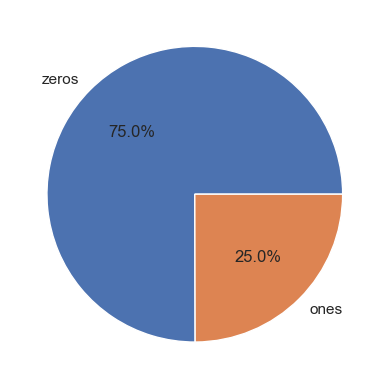

In [94]:
labels = merged_df['label']
labels = np.array(labels)
zeros, ones = 0, 0
for i in range(len(labels)):
    if labels[i] == 0:
        zeros += 1
    else:
        ones += 1
        
print('zeros: ', str(zeros))
print('ones: ', str(ones))

plt.pie([zeros, ones], labels=['zeros', 'ones'], autopct='%1.1f%%')

## Random Under Sampling

In [95]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.75, random_state=102)
# define model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
# make prediction
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.64      0.71      0.68      1263
     class 1       0.67      0.60      0.63      1233

    accuracy                           0.66      2496
   macro avg       0.66      0.66      0.65      2496
weighted avg       0.66      0.66      0.65      2496



## Random Over Sampling

In [96]:
from imblearn.over_sampling import RandomOverSampler

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, train_size=0.75, random_state=102)
# define model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
# make prediction
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.92      0.92      0.92      3751
     class 1       0.92      0.92      0.92      3753

    accuracy                           0.92      7504
   macro avg       0.92      0.92      0.92      7504
weighted avg       0.92      0.92      0.92      7504



## Synthetic Minority Over-Sampling Technique (SMOTE)

In [97]:
from imblearn.over_sampling import SMOTE

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=0.75, random_state=102)
# define model
lr_model = RandomForestClassifier()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.82      0.88      0.85      3751
     class 1       0.87      0.80      0.84      3753

    accuracy                           0.84      7504
   macro avg       0.85      0.84      0.84      7504
weighted avg       0.85      0.84      0.84      7504



# Modelling

## Final Data

In [98]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report

In [99]:
def transformData(X , y, n_components = 13, outlier = True):
      X = PCA(n_components = n_components).fit_transform(X)

      ros = RandomOverSampler(random_state=42)
      X_ros, y_ros = ros.fit_resample(X, y)

      X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, train_size=0.75, random_state=102)

      if outlier:
            # identify outliers in the training dataset
            iso = IsolationForest(contamination=0.05)
            x_out = iso.fit_predict(X_train)
            # select all rows that are not outliers
            mask = (x_out != -1)
            X_train, y_train = X_train[mask], y_train[mask]

      return X_train, X_test, y_train, y_test

In [100]:
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train,y_test = transformData(X,y)

## Picking Models

In [101]:
#baseline classifiers
classifiers = {"knn" : KNeighborsClassifier(), "SVM" : SVC(), "CART" : DecisionTreeClassifier(),
               "Logistic\nRegression": LogisticRegression(), "NaiveBayes" : GaussianNB(),
               "Random\nForest": RandomForestClassifier(), "XGBClassifier" : XGBClassifier(),
               "Adaboost": AdaBoostClassifier()}

accuracies = []
f1_scores = []

#getting baseline accuracies
for classifierName in classifiers:
    with mlflow.start_run(run_name = f'baseline model selection: {classifierName}'):
        #getting the classifier
        classifier = classifiers[classifierName]
        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', 13)
        mlflow.log_param('outliers' , True)

        mlflow.sklearn.log_model(classifier , f"models")

#making accuracies dict into a pandas dataframe    
df_baselines = pd.DataFrame()
df_baselines['accuracy'] = accuracies
df_baselines['f1_scores'] = f1_scores
df_baselines['classifiers'] = classifiers.keys()

df_baselines = df_baselines.melt(id_vars = ['classifiers'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

In [102]:
def plot(data , x_label):
    ax = sns.barplot(x = x_label,  y = 'scores', hue = "Type",data = data)
    ax.set_title("Baseline scores")
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.3f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 5),  
                        textcoords = 'offset points')
    ax.figure.autofmt_xdate()
    ax.figure.set_size_inches((14,8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)    
    plt.show()

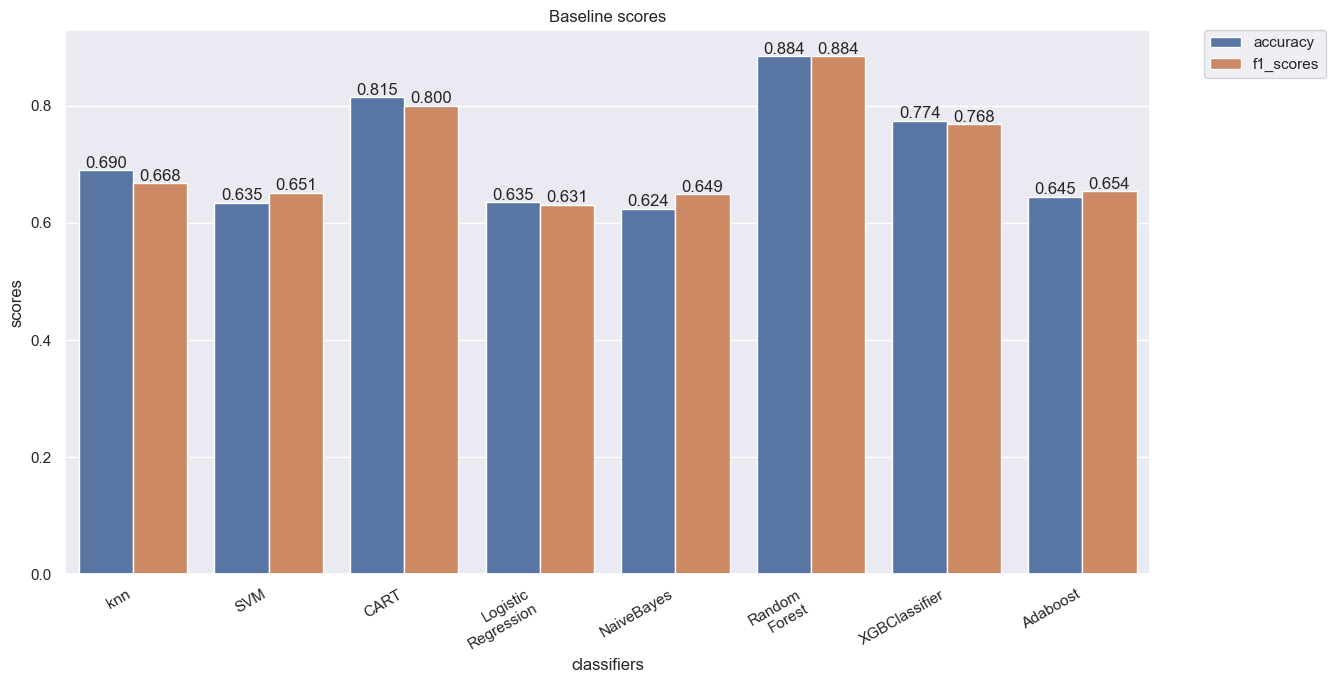

In [103]:
plot(df_baselines, 'classifiers')

In [104]:
accuracies = []
f1_scores = []

merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

for i in [True,False]:
    with mlflow.start_run(run_name = f'Outlier Detection {i}'):
        classifier = RandomForestClassifier()
        X_train, X_test, y_train,y_test = transformData(X,y, outlier = i)

        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', 13)
        mlflow.log_param('outliers' , i)

        mlflow.sklearn.log_model(classifier , f"Outlier experiment Randomforest")
        

#making accuracies dict into a pandas dataframe    
df_outliers = pd.DataFrame()
df_outliers['accuracy'] = accuracies
df_outliers['f1_scores'] = f1_scores
df_outliers['outliers'] = [True , False]

df_outliers = df_outliers.melt(id_vars = ['outliers'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

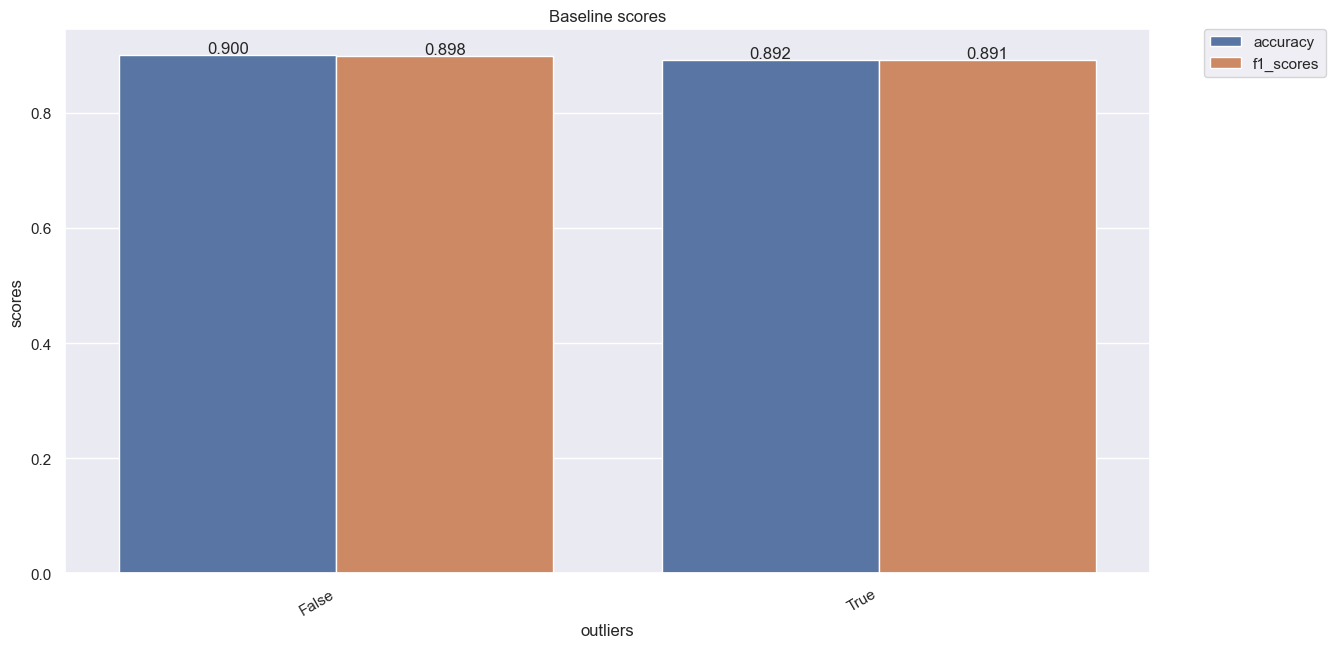

In [105]:
plot(df_outliers , "outliers")

In [106]:
accuracies = []
f1_scores = []

merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

for i in range(13,26):
    with mlflow.start_run(run_name = f'Component Analysis: {i}'):   
        classifier = RandomForestClassifier()
        X_train, X_test, y_train,y_test = transformData(X, y, n_components=i, outlier = False)

        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', i)
        mlflow.log_param('outliers' , False)

        mlflow.sklearn.log_model(classifier , f"PCA experiment Randomforest")

#making accuracies dict into a pandas dataframe    
df_components = pd.DataFrame()
df_components['accuracy'] = accuracies
df_components['f1_scores'] = f1_scores
df_components['components'] = list(range(13,26))

df_components = df_components.melt(id_vars = ['components'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

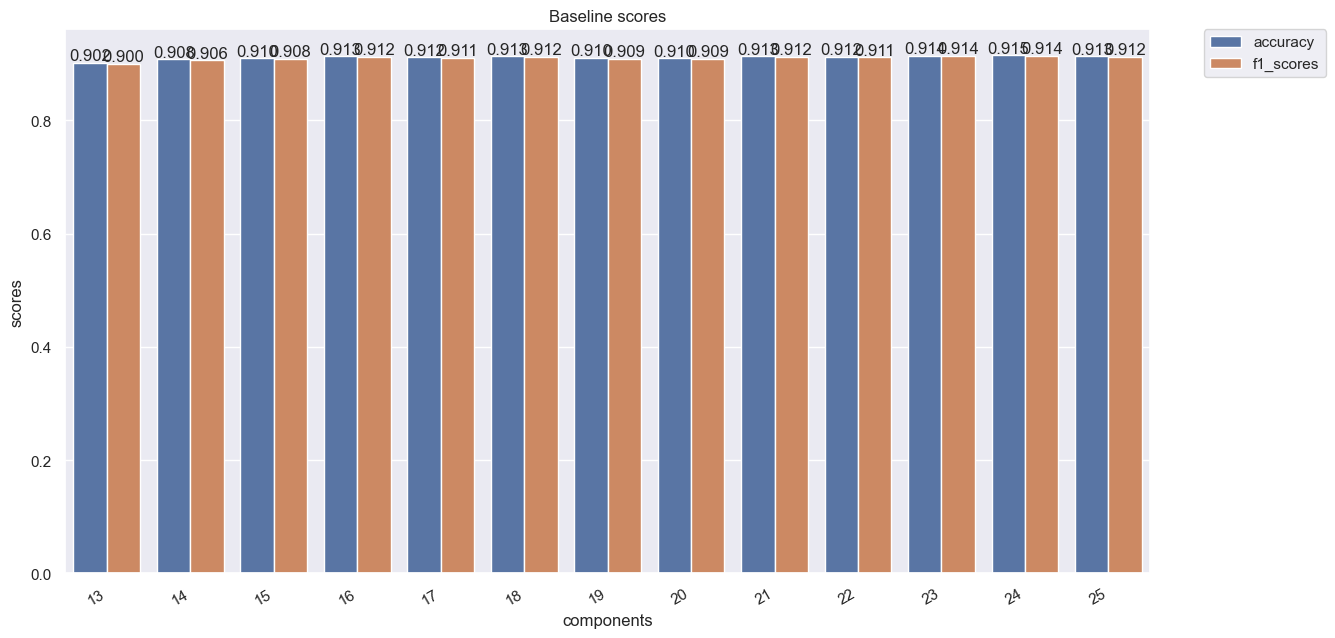

In [107]:
plot(df_components , "components")

# Final

In [119]:
from sklearn.model_selection import GridSearchCV

# best parameters model
X_train, X_test, y_train, y_test = transformData(X,y,n_components=23, outlier = False)

#ADD GRIDSEARCH CODE HERE
class CustomRandomForestClassifier(RandomForestClassifier):
    '''
    A custom random forest classifier.
    The RandomForestClassifier class is extended by adding a callback function within its fit method.
    '''
    def fit(self, X, y, **kwargs):
        super().fit(X, y)
        # if a "callback" key is passed, call the "callback" function by passing the fitted estimator
        if 'callback' in kwargs: 
            kwargs['callback'](self)
        return self


class Logger:
    '''
    Logger class stores the test dataset,
    and logs sklearn random forest estimator in rf_logger method.
    '''
    def __init__(self, test_X, test_y):
        self.test_X = test_X
        self.test_y = test_y

    def rf_logger(self, model):
        # log the random forest model in nested mlflow runs
        with mlflow.start_run(nested=True):
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("max_leaf_nodes", model.max_leaf_nodes)
            mlflow.log_metric("score", model.score(self.test_X, self.test_y))
            mlflow.sklearn.log_model(model, 'rf_model')
        return None

crf = CustomRandomForestClassifier(random_state=9)
param_grid = {'n_estimators': (200, 400, 600, 800, 1000),
              'criterion': ('gini', 'entropy', 'log_loss'),
              'max_depth': (np.arange(10, 101, 20)),
              'max_features': ('auto', 'sqrt', 'log2'),
              'min_samples_leaf': (1, 2, 4),
              'min_samples_split': (2, 5, 10)}

# Use custom random forest classifier while defining the estimator for grid search 
grid = GridSearchCV(crf, param_grid, cv=5, refit=True, scoring = 'f1', verbose = 2, n_jobs = -1)


# Instantiate Logger with test dataset
logger = Logger(X_test, y_test)

# start outer mlflow run and perform grid search with cross-validation
with mlflow.start_run(run_name = "Grid Search"):
    # while calling GridSearchCV object's fit method pass logger.rf_logger
    # logger.rf_logger takes care of logging each fitted model during gridsearch
    grid.fit(X_train, y_train, callback = logger.rf_logger)

    # log the best estimator fround by grid search in the outer mlflow run 
    mlflow.log_param("n_estimators", grid.best_params_["n_estimators"])
    mlflow.log_param("criterion", grid.best_params_["criterion"])
    mlflow.log_param("max_depth", grid.best_params_["max_depth"])
    mlflow.log_param("max_features", grid.best_params_["max_features"])
    mlflow.log_param("min_samples_leaf", grid.best_params_["min_samples_leaf"])
    mlflow.log_param("min_samples_split", grid.best_params_["min_samples_split"])
    mlflow.log_metric("score", grid.score(X_test, y_test))
    mlflow.sklearn.log_model(grid.best_estimator_, 'best_rf_model')

Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


In [ ]:
print(f'''
n_estimators: {grid.best_params_['n_estimators']}
criterion:  {grid.best_params_['criterion']}
max_depth: {grid.best_params_['max_depth']}
max_features: {grid.best_params_['max_features']}
score: {grid.score(X_test, y_test)}
''')


n_estimators: 200
criterion:  gini
max_depth: 50
max_features: auto
score: 0.9177500663305916

